In [1]:
from bs4 import BeautifulSoup
# import xml.etree.ElementTree as et
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import dask.bag as bag
from dask.diagnostics import ProgressBar
from PIL import Image
import math

In [2]:
sn.set(rc={'figure.figsize':(11,8)})

In [3]:
# xml_files = glob.glob('D:/MSc scriptie/Data/xml2/*.xml')
xml_files = glob.glob('../Data/Rijksmuseum/xml2/*.xml')
print(len(xml_files))
    

112039


In [4]:
xml_files[0]

'../Data/Rijksmuseum/xml2\\0000001_SK-A-4878.xml'

In [5]:
with open(xml_files[0], 'r', encoding="utf8") as f:
    data = f.read()
    
bs_data = BeautifulSoup(data, "xml")

In [6]:
print(bs_data.prettify())
# bs_data

<?xml version="1.0" encoding="utf-8"?>
<record>
 <header>
  <identifier>
   oai:rijksmuseum.nl/collection:SK-A-4878
  </identifier>
  <datestamp>
   2012-10-26T09:44:37Z
  </datestamp>
 </header>
 <metadata>
  <dc>
   <format>
    https://www.rijksmuseum.nl/assetimage2.jsp?id=SK-A-4878
   </format>
   <format>
    https://www.rijksmuseum.nl/nl/collectie/SK-A-4878
   </format>
   <identifier>
    SK-A-4878
   </identifier>
   <identifier>
    RM0001.COLLECT.2
   </identifier>
   <language>
    Dutch
   </language>
   <publisher>
    Rijksmuseum
   </publisher>
   <rights>
    http://creativecommons.org/publicdomain/zero/1.0/
   </rights>
   <date>
    1644 -  1648
   </date>
   <description>
    Een jonge vrouw haar handen warmend boven gloeiende kolen in een aardewerken vuurtest. Waarschijnlijk een allegorie op het seizoen Winter. De vrouw draagt een witte muts, oorbellen en een parelsnoer.
   </description>
   <format>
    hoogte 97 CMcmcm
   </format>
   <format>
    breedte 81 CMcmc

In [7]:
# bs_data.find('metadata').find('identifier')
unordered_list = bs_data.find("metadata")
print(unordered_list)

<metadata>
<dc>
<format>https://www.rijksmuseum.nl/assetimage2.jsp?id=SK-A-4878</format>
<format>https://www.rijksmuseum.nl/nl/collectie/SK-A-4878</format>
<identifier>SK-A-4878</identifier>
<identifier>RM0001.COLLECT.2</identifier>
<language>Dutch</language>
<publisher>Rijksmuseum</publisher>
<rights>http://creativecommons.org/publicdomain/zero/1.0/</rights>
<date>1644 -  1648</date>
<description>Een jonge vrouw haar handen warmend boven gloeiende kolen in een aardewerken vuurtest. Waarschijnlijk een allegorie op het seizoen Winter. De vrouw draagt een witte muts, oorbellen en een parelsnoer.</description>
<format>hoogte 97 CMcmcm</format>
<format>breedte 81 CMcmcm</format>
<format>diepte 8 CMcmcm</format>
<format>materiaal: olieverf</format>
<format>materiaal: doek</format>
<creator> schilder: Everdingen, Caesar Boëtius van</creator>
<coverage>Nederland</coverage>
<type>schilderij</type>
<title>Een jonge vrouw haar handen warmend boven een vuurtest, mogelijk een allegorie op de Winte

In [31]:
def remove_tags(bs_data, tag):
    node = bs_data.find('metadata').find(tag)
    if node:
        string = ''.join(node.stripped_strings)
    else:
        string = ':'
#     string = string.split(':')[1]
    return string

In [35]:
def remove_mats(bs_data, tag):
    mats = []
    nodes = bs_data.find('metadata').find_all(tag)
    for node in nodes:
        tag = ''.join(node.stripped_strings)
#         print(tag)
        if 'materiaal' in tag:
            mats.append(tag.split(':')[-1][1:])

    return mats

In [36]:
creator = remove_tags(bs_data, 'creator').split(':')[1][1:]
creator

'Everdingen, Caesar Boëtius van'

In [37]:
identifier = remove_mats(bs_data, 'format')
identifier

['olieverf', 'doek']

In [44]:
identifier = remove_tags(bs_data, 'date')[-4:]
identifier

'1648'

In [54]:
def create_df(xml_files):
    tags = []
    all_items = []
    
    for i in range(len(xml_files)):
        if i % 4000 == 0:
            print(str(round(i/len(xml_files)*100, 3)) + '%')
            
        with open(xml_files[i], 'r', encoding="utf8") as f:
            data = f.read()
            
        bs_data = BeautifulSoup(data, "xml")
        
        identifier = remove_tags(bs_data, 'identifier')
        creator = remove_tags(bs_data, 'creator').split(':')[1][1:]
        title = remove_tags(bs_data, 'title')
        date = remove_tags(bs_data, 'date')
        date = remove_tags(bs_data, 'date')[-4:]
        art_type = remove_tags(bs_data, 'type')
        materials = remove_mats(bs_data, 'format')
#         creators[identifier] = creator
        tags = [identifier, creator, title, date, art_type, materials]
        all_items.append(tags)
        
    df = pd.DataFrame(all_items, columns=['Identifier', 'Creator', 'Title', 'Date', 'Type', 'Materials'])
#     return pd.DataFrame.from_dict(creators)
    return df
        

In [55]:
creators = create_df(xml_files)

0.0%
3.57%
7.14%
10.711%
14.281%
17.851%
21.421%
24.991%
28.561%
32.132%
35.702%
39.272%
42.842%
46.412%
49.983%
53.553%
57.123%
60.693%
64.263%
67.834%
71.404%
74.974%
78.544%
82.114%
85.684%
89.255%
92.825%
96.395%
99.965%


In [56]:
creators

,Identifier,Creator,Title,Date,Type,Materials
0,SK-A-4878,"Everdingen, Caesar Boëtius van",Een jonge vrouw haar handen warmend boven een ...,1648,schilderij,"[olieverf, doek]"
1,SK-A-4877,"Maris, Matthijs",Portret van Jacob Maris,1857,schilderij,"[papier, olieverf, hout]"
2,SK-A-4881,"Maes, Nicolaes","Portret van een jonge man, waarschijnlijk Simo...",1685,schilderij,"[olieverf, doek]"
3,RP-P-1992-35,"Coornhert, Dirck Volckertsz",Keizer Karel V omgeven door zijn overwonnen te...,1555,prent,"[papier, dekverf]"
4,RP-P-1992-36,"Coornhert, Dirck Volckertsz",Gevangename van Frans I tijdens de slag van Pa...,1556,prent,"[papier, dekverf]"
...,...,...,...,...,...,...
112034,AK-RBK-14763-A-2,anoniem,Schotel beschilderd met lotusranken en een kra...,1725,schotel,"[porselein, glazuur]"
112035,RP-P-OB-86.512,"Bos, Maarten",Beschieting van het Nederlandse oorlogsschip M...,1863,prent,[papier]
112036,NG-NM-7753,anoniem,Inktpot met deksel,1596,inktpot,[lood (materiaal)]
112037,NG-NM-8358,"Coenraads, Jacobus (Senior)",Hartsvanger van Schout bij nacht J.A. Zoutman,1790,hartsvanger,"[ijzer, been, zilver]"


In [57]:
creators_test = creators

In [59]:
creators_test['Date'].unique()

array(['1648', '1857', '1685', '1555', '1556', '1553', '1706', '1626',
       '1589', '1610', '1220', '1799', '1724', ':', '1000', '1350',
       '1810', '1774', '1826', '4-08', '1780', '1715', '1734', '1770',
       '1746', '-200', '-800', '-250', '-100', ' 100', ' 300', '1100',
       ' 906', ' 800', ' 750', ' 700', ' 500', ' 220', '1400', '1644',
       '1279', ' 950', '1800', '1200', '1500', '1300', '1600', ' 200',
       '1789', '1825', '1779', '1790', '1758', '1765', '1778', '1727',
       '1802', '1829', '1750', '1713', '1718', '1796', '1806', '1811',
       '1822', '1745', '1815', '1812', '1784', '1777', '1793', '1574',
       '1620', '1570', '1550', '1699', ' 512', ' 525', ' 618', '1150',
       '1250', '1850', '1900', '1650', '1700', '1875', '1725', '1830',
       '1775', '1127', '1795', '1368', '1735', '1625', '1722', '1640',
       '1720', '1645', '1660', '1808', '1803', '1599', '1586', '1755',
       '1566', '1607', '1602', '1575', '1731', '1732', '1581', '1680',
       '2

In [60]:
creators.to_csv('xml_files_full.csv', index=False)

In [12]:
# creators.to_csv('xml_files.csv', index=False)
# creators = pd.read_csv('../Data/Rijksmuseum/xml_files.csv')
creators = pd.read_csv('D:/MSc scriptie/Data/Rijksmuseum/xml_files.csv')
creators

,Identifier,Creator,Title,Date,Type
0,SK-A-4878,"Everdingen, Caesar Boëtius van",Een jonge vrouw haar handen warmend boven een ...,1644 - 1648,schilderij
1,SK-A-4877,"Maris, Matthijs",Portret van Jacob Maris,1857 - 1857,schilderij
2,SK-A-4881,"Maes, Nicolaes","Portret van een jonge man, waarschijnlijk Simo...",1675 - 1685,schilderij
3,RP-P-1992-35,"Coornhert, Dirck Volckertsz",Keizer Karel V omgeven door zijn overwonnen te...,1555 - 1555,prent
4,RP-P-1992-36,"Coornhert, Dirck Volckertsz",Gevangename van Frans I tijdens de slag van Pa...,1555 - 1556,prent
...,...,...,...,...,...
112034,AK-RBK-14763-A-2,anoniem,Schotel beschilderd met lotusranken en een kra...,ca. 1700 - ca. 1725,schotel
112035,RP-P-OB-86.512,"Bos, Maarten",Beschieting van het Nederlandse oorlogsschip M...,1863 - 1863,prent
112036,NG-NM-7753,anoniem,Inktpot met deksel,ca. 1590 - ca. 1596,inktpot
112037,NG-NM-8358,"Coenraads, Jacobus (Senior)",Hartsvanger van Schout bij nacht J.A. Zoutman,1774 - 1790,hartsvanger


In [39]:
creators.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112039 entries, 0 to 112038
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Identifier  112039 non-null  object
 1   Creator     111186 non-null  object
 2   Title       112017 non-null  object
 3   Date        112039 non-null  object
 4   Type        112012 non-null  object
dtypes: object(5)
memory usage: 4.3+ MB


In [26]:
creators[creators['Identifier'].str.contains('RP-P-OB-20.863')]

,Identifier,Creator,Title,Date,Type
19772,RP-P-OB-20.863,"Callot, Jacques",Feest te Florence: praalwagen van Atlas en de zon,1616 - 1616,prent


In [14]:
no_anons = creators[(creators['Creator'] != '') & (creators['Creator'] != ' anoniem')]
no_anons

,Identifier,Creator,Title,Date,Type
0,SK-A-4878,"Everdingen, Caesar Boëtius van",Een jonge vrouw haar handen warmend boven een ...,1644 - 1648,schilderij
1,SK-A-4877,"Maris, Matthijs",Portret van Jacob Maris,1857 - 1857,schilderij
2,SK-A-4881,"Maes, Nicolaes","Portret van een jonge man, waarschijnlijk Simo...",1675 - 1685,schilderij
3,RP-P-1992-35,"Coornhert, Dirck Volckertsz",Keizer Karel V omgeven door zijn overwonnen te...,1555 - 1555,prent
4,RP-P-1992-36,"Coornhert, Dirck Volckertsz",Gevangename van Frans I tijdens de slag van Pa...,1555 - 1556,prent
...,...,...,...,...,...
112004,RP-P-2011-173-1,"Fellmann, M.","Apostel Jacobus Maior, allegorie op tabak",ca. 1800 - ca. 1900,prent
112005,RP-T-1886-A-704-26,"Bramer, Leonaert",Berglandschap,1652 - 1653,tekening
112035,RP-P-OB-86.512,"Bos, Maarten",Beschieting van het Nederlandse oorlogsschip M...,1863 - 1863,prent
112037,NG-NM-8358,"Coenraads, Jacobus (Senior)",Hartsvanger van Schout bij nacht J.A. Zoutman,1774 - 1790,hartsvanger


In [15]:
creators[creators.index == 112036].Creator.values

array([' anoniem'], dtype=object)

In [16]:
no_anons = no_anons[no_anons['Creator'].notna()]
no_anons

,Identifier,Creator,Title,Date,Type
0,SK-A-4878,"Everdingen, Caesar Boëtius van",Een jonge vrouw haar handen warmend boven een ...,1644 - 1648,schilderij
1,SK-A-4877,"Maris, Matthijs",Portret van Jacob Maris,1857 - 1857,schilderij
2,SK-A-4881,"Maes, Nicolaes","Portret van een jonge man, waarschijnlijk Simo...",1675 - 1685,schilderij
3,RP-P-1992-35,"Coornhert, Dirck Volckertsz",Keizer Karel V omgeven door zijn overwonnen te...,1555 - 1555,prent
4,RP-P-1992-36,"Coornhert, Dirck Volckertsz",Gevangename van Frans I tijdens de slag van Pa...,1555 - 1556,prent
...,...,...,...,...,...
112004,RP-P-2011-173-1,"Fellmann, M.","Apostel Jacobus Maior, allegorie op tabak",ca. 1800 - ca. 1900,prent
112005,RP-T-1886-A-704-26,"Bramer, Leonaert",Berglandschap,1652 - 1653,tekening
112035,RP-P-OB-86.512,"Bos, Maarten",Beschieting van het Nederlandse oorlogsschip M...,1863 - 1863,prent
112037,NG-NM-8358,"Coenraads, Jacobus (Senior)",Hartsvanger van Schout bij nacht J.A. Zoutman,1774 - 1790,hartsvanger


In [17]:
no_anons.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94668 entries, 0 to 112038
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Identifier  94668 non-null  object
 1   Creator     94668 non-null  object
 2   Title       94646 non-null  object
 3   Date        94668 non-null  object
 4   Type        94654 non-null  object
dtypes: object(5)
memory usage: 4.3+ MB


In [62]:
nan_rows = no_anons[no_anons['Creator'].isnull()]
math.isnan(nan_rows.iloc[2, 1])

True

In [5]:
# no_anons.to_csv('xml_files_no_anons.csv', index=False)
# creators.to_csv('xml_files.csv', index=False)

In [6]:
# test = creators[creators.Identifier == 'NG-NM-7753']['Creator']
no_anons.loc[no_anons.Identifier=='SK-A-4878','Creator'].values[0]

'Everdingen, Caesar Boëtius van'

In [18]:
unique_creators = creators['Creator'].unique()
len(unique_creators)

6622

In [20]:
grouped = no_anons.groupby('Creator').count()

grouped = grouped.sort_values('Title', ascending=False)
# selection = grouped
grouped = grouped.reset_index()
# grouped = grouped.drop([0, 11])
grouped.head(15)

,Creator,Identifier,Title,Date,Type
0,"Luyken, Jan",1928,1928,1928,1928
1,"Picart, Bernard",1504,1504,1504,1504
2,Rembrandt Harmensz. van Rijn,1384,1384,1384,1384
3,"Fokke, Simon",1267,1267,1267,1267
4,"Houbraken, Jacob",1148,1148,1148,1148
5,"Hooghe, Romeyn de",1119,1119,1119,1119
6,"Callot, Jacques",1013,1013,1013,1013
7,Meissener Porzellan Manufaktur,1003,1003,1003,1003
8,"Gheyn, Jacob de (II)",893,893,893,893
9,"Passe, Crispijn van de (I)",856,856,856,856


In [21]:
grouped.iloc[11]['Creator']

' Goltzius, Hendrick'

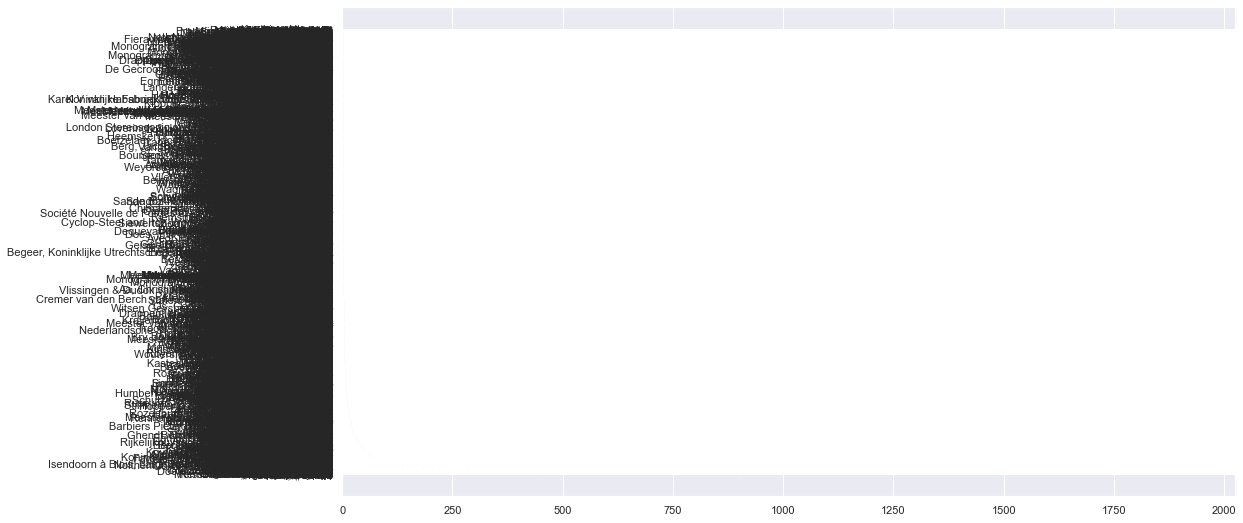

In [10]:
# fig, ax = plt.subplots(figsize =(16, 9))
# # plt.bar(selection['Creator'], selection['Title'])
# ax.barh(grouped['Creator'], grouped['Title'])
# plt.show()

In [69]:
frequents = grouped[grouped['Title'] >= 10]

In [73]:
frequents.Type.sum()

82588

In [71]:
frequents.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1196 entries, 0 to 1195
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Creator     1196 non-null   object
 1   Identifier  1196 non-null   int64 
 2   Title       1196 non-null   int64 
 3   Date        1196 non-null   int64 
 4   Type        1196 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 56.1+ KB


C:\Users\Lotte\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


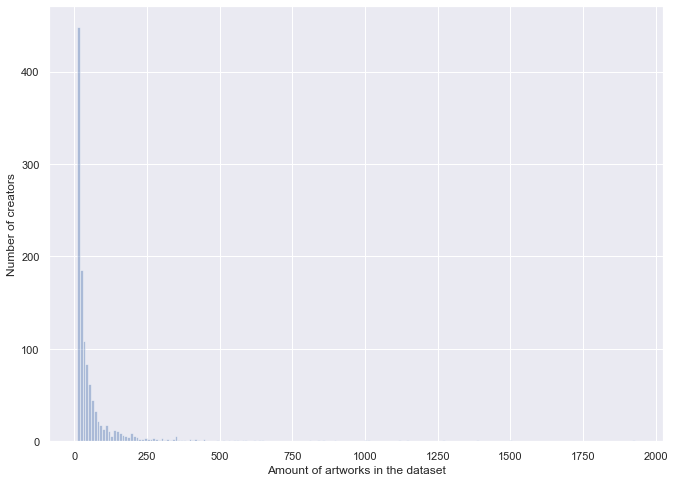

In [74]:
ax = sn.distplot(frequents['Title'], bins=200, hist=True, kde=False, rug=False)
ax.set(xlabel="Amount of artworks in the dataset", ylabel="Number of creators")
plt.show()

In [75]:
def get_dims(file):
    '''Returns dimenstions for an RBG image'''
    im = Image.open(file)
    arr = np.array(im)
    dims = arr.shape
    return dims[0], dims[1]

In [35]:
img_files = glob.glob('../Data/Rijksmuseum/jpg2/*.jpg')

[########################################] | 100% Completed | 38.2s


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


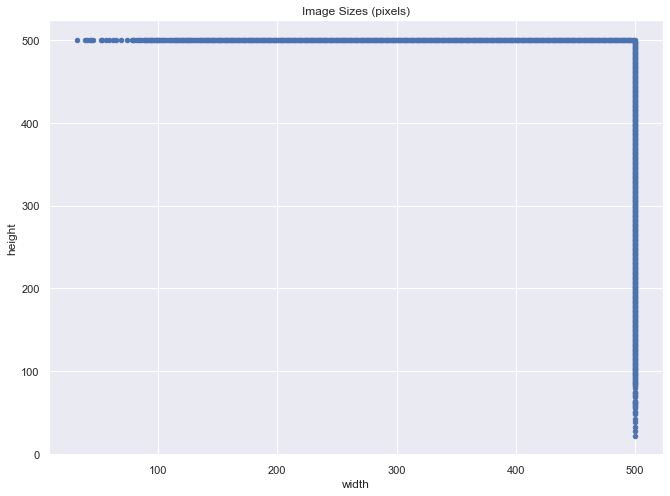

In [38]:
dims = bag.from_sequence(img_files).map(get_dims)
with ProgressBar():
    dims = dims.compute()
    dim_df = pd.DataFrame(dims, columns=['height', 'width'])
    sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})
    sizes.plot.scatter(x='width', y='height');
    plt.title('Image Sizes (pixels)')